## Summary
- **Data Preparation**:
    - Some posts had the same URL but different scores, with identical features like author and datetime. To eliminate bias from these duplications, I deduplicated the posts, keeping only the one with the highest score.


- **Defining Successful Posts**:
    - A successful post is defined by its high score. Posts with scores above the **75th** percentile are considered successful.
    

- **Key Findings**(All the following attributes contributin a successful post):
    - **Popular Tags**:
        - Biology and Physics are the most popular tags on r/askscience. Subcategories like Human Body and Earth Science are subsets of these two categories. Posts related to these topics have a higher likelihood of success.
    - **Current Events**:
        - Starting in March 2020, COVID-19 became a global pandemic, leading to a surge in discussions on this topic. Successful posts often revolve around current, real-time hot topics.
    - **Upvote Ratio**:
        - To be considered successful, a post should have an upvote ratio of at least **0.95**. This threshold helps exclude bot posts and toxic content.
    - **Title and Body Length**:
    The title length should be around 100 characters and convey important information. An empty body is acceptable if the title provides a clear description.
    - **Sentiment Analysis**:
        - Neutral titles are more likely to be associated with successful posts.
    - **Topic Extraction**:
        - Using a document frequency threshold (0.9 max, 5 min) to exclude overly frequent or rare words, the following general topics were identified:

            - **Practical Applications and Natural Science**: Focuses on practical applications and natural phenomena, emphasizing explanatory content.
            - **Health and Pandemic**: Centers on health, particularly the COVID-19 pandemic, and includes personal health and behavioral discussions.
            - **Community Engagement and Space**: Highlights community-driven content, space-related discussions, and broader scientific inquiries.
        - **Biology Topics**:
            - **Life and Natural Processes**: Discusses aging, species, genetic material, and aquatic life, exploring life cycles and survival.
            - **Human and Plant Interactions**: Revolves around interactions between humans and other organisms, covering health, domestic animals, and ecological discussions.
            - **Time and Species Diversity**: Emphasizes temporal aspects and species diversity, discussing pathogens and understanding biological phenomena.
        - **Physics Topics**:
            - **Fundamental Concepts and Celestial Bodies**: Focuses on gravitational phenomena, celestial objects, and basic principles.
            - **Energy and Relativity**: Emphasizes energy, relativity, and astrophysical phenomena.
            - **Astrophysics and Theoretical Concepts**: Revolves around astrophysics and theoretical physics, discussing feasibility, scale, nuclear physics, and time.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy

In [25]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/d.liu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/d.liu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Load Data Set

In [26]:
# Load the dataset
file_path = 'askscience_data.csv'
data = pd.read_csv(file_path)

In [27]:
data.shape

(4205, 9)

## 2. Pre-Processing
- Some posts had the same URL value but different scores, while other features, such as author and datetime, were identical. The difference between the scores was small. To eliminate any bias caused by these duplications, I deduplicated the posts, retaining only the one with the highest score.

In [28]:
# de-dup
data = data.sort_values(by='score', ascending=False).drop_duplicates(subset=['url'],keep='first')

In [29]:
# str -> datetime
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['year'] = data['datetime'].dt.to_period('Y')
data['year_month'] = data['datetime'].dt.to_period('M')

## 3. Data Analysis

### 3.1 Define successful posts
- A successful post is defined by its high score.
- The score distribution shows a long tail for high-scoring posts. To identify clear patterns, we define successful posts as those with scores above the **75th** percentile.

In [30]:
data['score'].describe()

count     3707.000000
mean      2890.544106
std       5176.063038
min          0.000000
25%          3.000000
50%         18.000000
75%       6441.000000
max      83382.000000
Name: score, dtype: float64

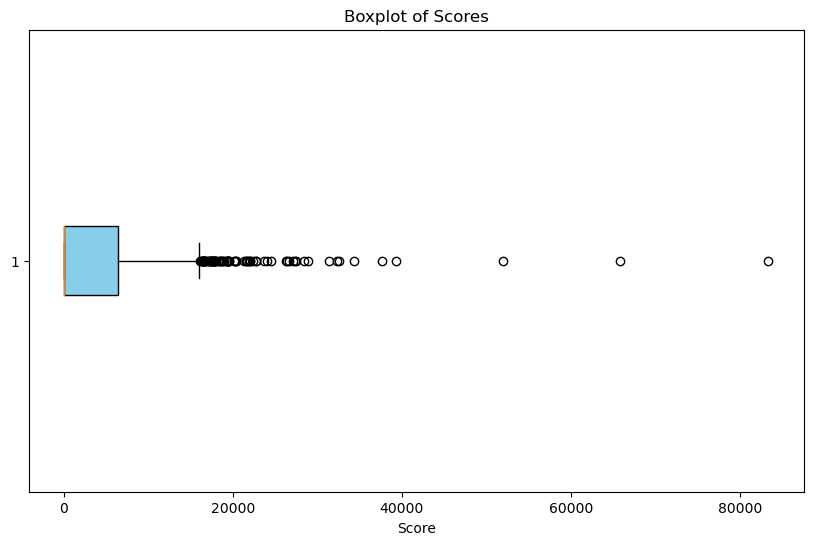

In [31]:
# Create a boxplot for the 'score' column
plt.figure(figsize=(10, 6))
plt.boxplot(data['score'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Boxplot of Scores')
plt.xlabel('Score')
plt.show()

In [32]:
score_percentile = data['score'].quantile(0.75)
successful_posts = data[data['score'] >= score_percentile]

### 3.2 Tag Distribution
- **Biology** and **Physics** are the most popular tags on r/askscience. Additionally, Human Body and Earth Science appear to be subsets of these two categories.
- This indicates that posts related to these categories have a high likelihood of receiving high scores.

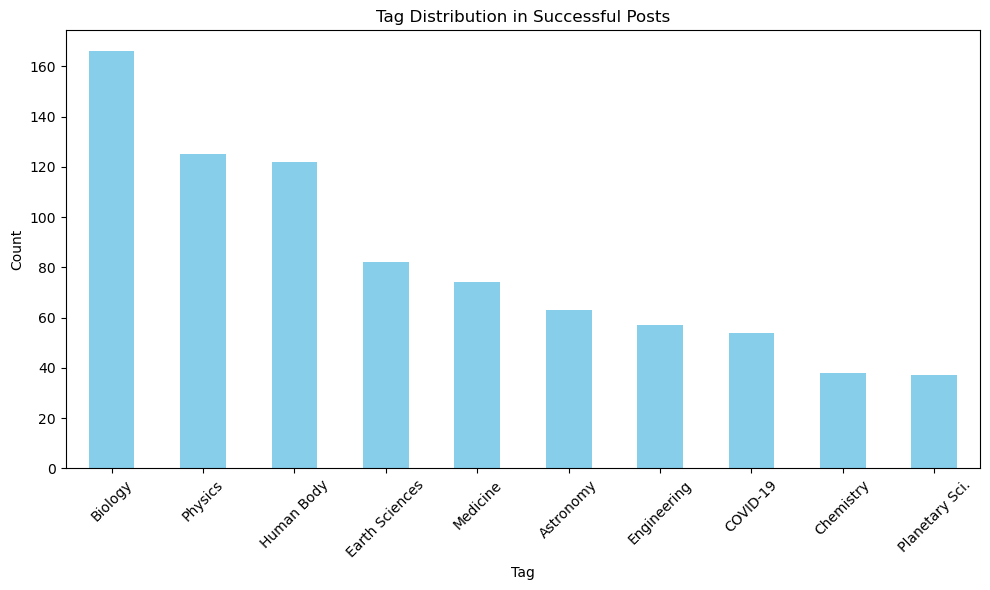

In [33]:
plt.figure(figsize=(10, 6))
sucessful_posts['tag'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Tag Distribution in Successful Posts')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.3 Year_Month
- Beginning in March 2020, COVID-19 became a global pandemic, leading to a surge in discussions on this topic.
- This suggests that successful posts often revolve around current, real-time hot topics.

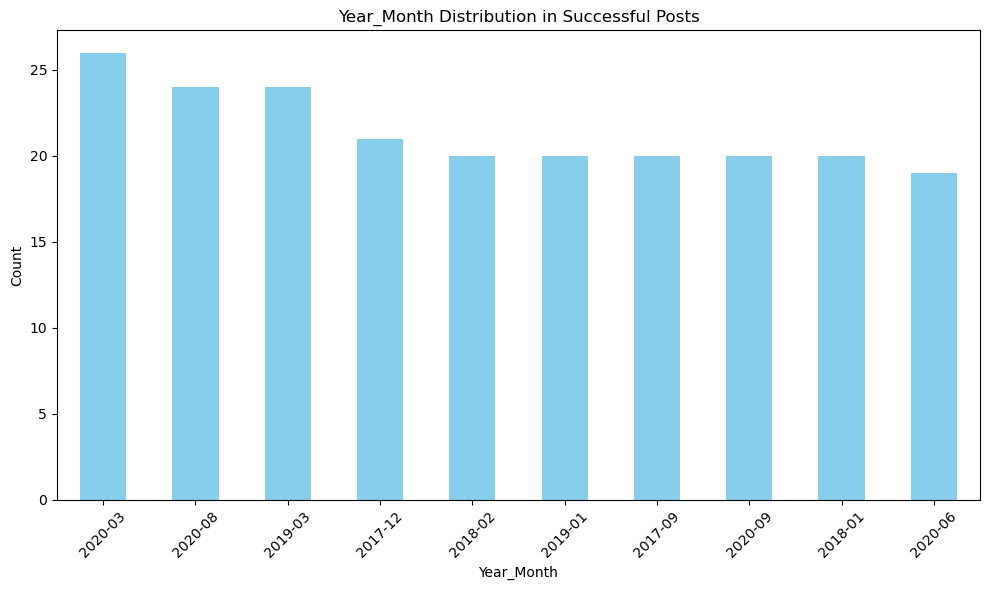

In [34]:
plt.figure(figsize=(10, 6))
sucessful_posts['year_month'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Year_Month Distribution in Successful Posts')
plt.xlabel('Year_Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.4 Upvote Ratio 
- To be considered successful, a post should have an upvote ratio of at least 0.95. This threshold helps exclude bot posts and toxic content.

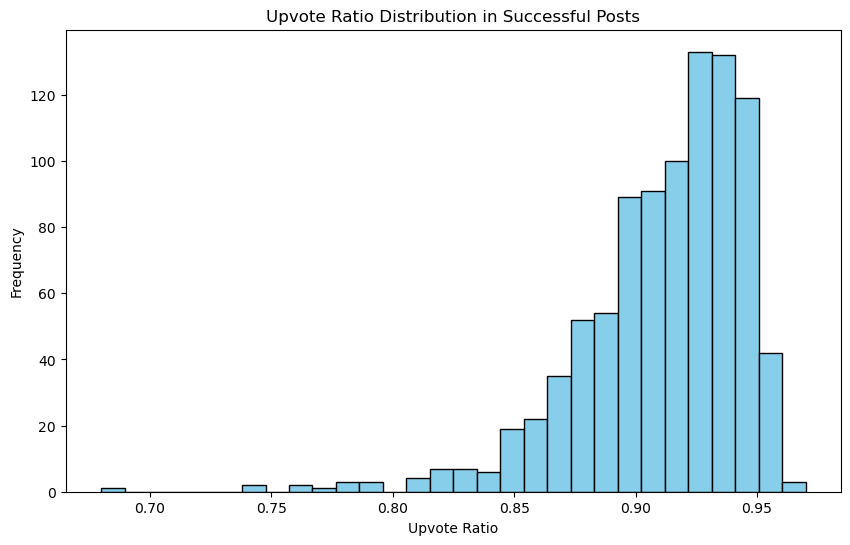

In [35]:
plt.figure(figsize=(10, 6))
sucessful_posts['upvote_ratio'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Upvote Ratio Distribution in Successful Posts')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')
plt.show()


### 3.5 Title and Body Length
- The title length should be around **100** characters and convey important information. An empty body is acceptable if the title provides a clear description.

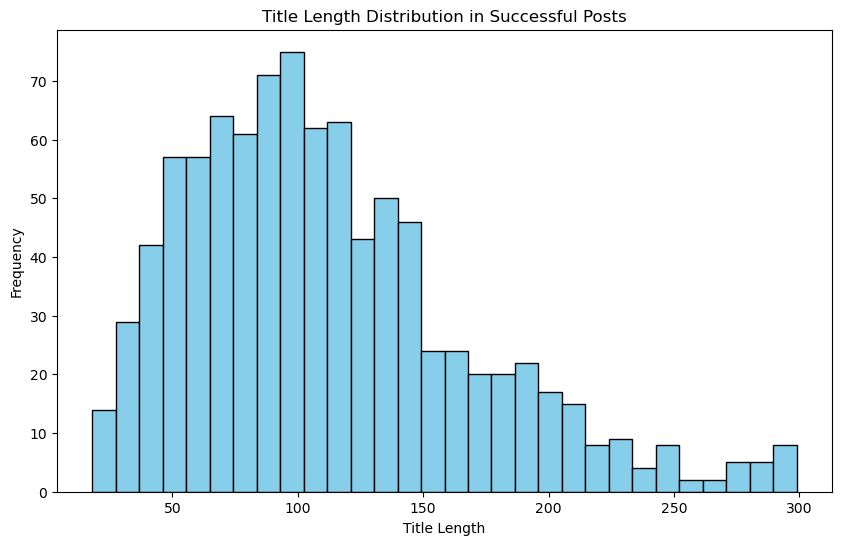

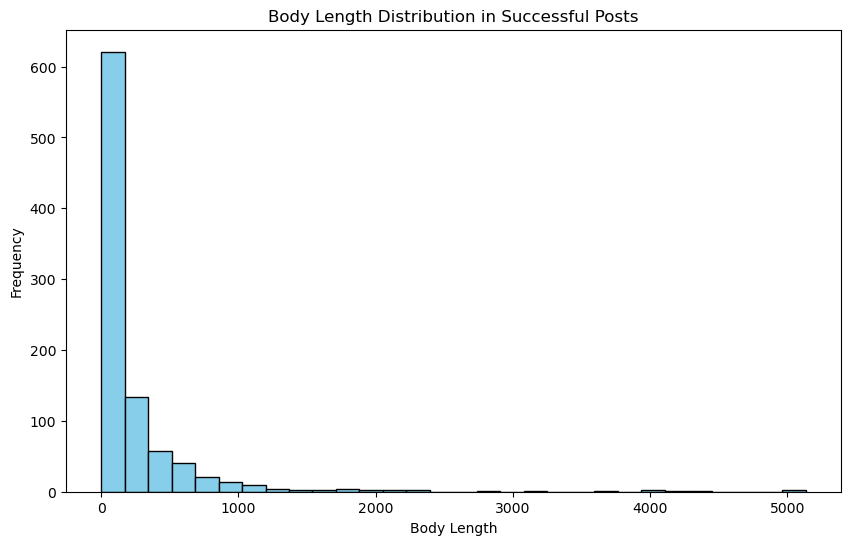

In [36]:
sucessful_posts['title_length'] = sucessful_posts['title'].apply(lambda x: len(x) if pd.notnull(x) else 0)
sucessful_posts['body_length'] = sucessful_posts['body'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Plot title length distribution
plt.figure(figsize=(10, 6))
sucessful_posts['title_length'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Title Length Distribution in Successful Posts')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.show()

# Plot body length distribution
plt.figure(figsize=(10, 6))
sucessful_posts['body_length'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Body Length Distribution in Successful Posts')
plt.xlabel('Body Length')
plt.ylabel('Frequency')
plt.show()

### 3.6 Sentiment Analysis
- Neutral titles are more likely to be associated with successful posts.

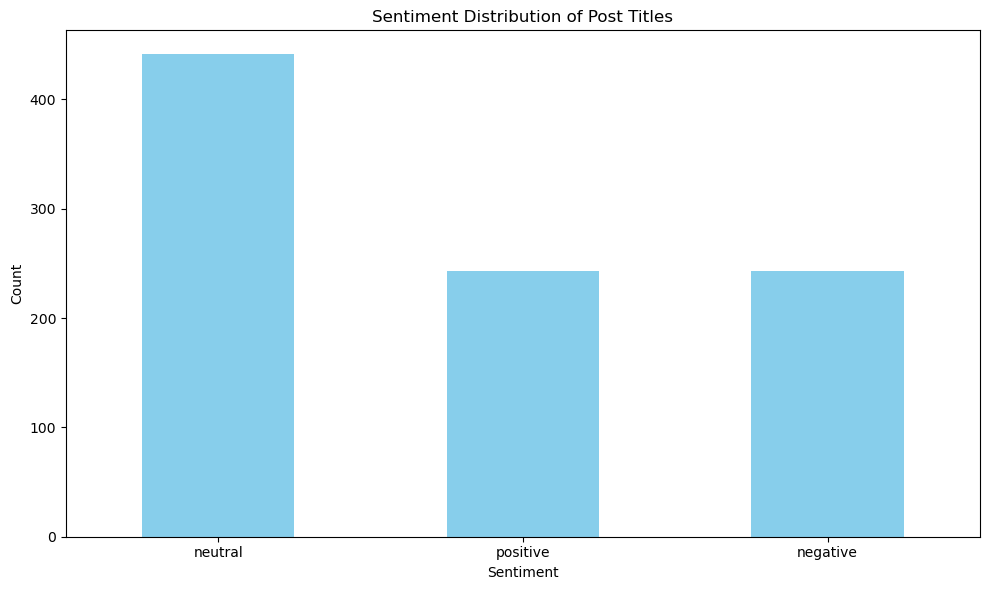

In [37]:
# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to classify sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Perform sentiment analysis on the titles
sucessful_posts['sentiment'] = sucessful_posts['title'].apply(lambda title: sid.polarity_scores(title)['compound'])
sucessful_posts['sentiment_class'] = sucessful_posts['sentiment'].apply(classify_sentiment)

# Plot the sentiment distribution
plt.figure(figsize=(10, 6))
sucessful_posts['sentiment_class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution of Post Titles')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### 3.7 Topic Extraction
- In order to find general patterns, step up the max and min document frequency as 0.9 and 5, to exclude too frequency words and rare words
- First, we explore the topics in general, find...
- Then we slice and dice the titles in biology and physics, which are the two hot topic across the successful post, find: 

#### 3.7.1 General Topic
- **Topic 1: Practical Applications and Natural Science**
    - This topic focuses on practical applications of science and natural phenomena. It includes discussions on the use of various elements (e.g., water, light), the feasibility of scientific concepts (possible), and natural sciences (sun, earth, body). The frequent use of "does" suggests an emphasis on explanatory content.
- **Topic 2: Health and Pandemic**
    - This topic centers around health, with a strong focus on the COVID-19 pandemic (covid, 19, vaccine, flu). It includes personal health (make, does) and behavioral discussions (just, don, like). The inclusion of "different" indicates comparative discussions or explanations.
- **Topic 3: Community Engagement and Space**
    - This topic highlights community-driven content and space-related discussions. It includes engagement through AMA (Ask Me Anything) sessions and discussions on r/askscience (askscience, ama). It also touches on space (space, black) and broader scientific inquiries (nuclear, know, person, people).

In [38]:
# Load Spacy English model
spacy_en = spacy.load('en_core_web_sm')


def extract_topics(titles, n_topics=3, max_df=0.9, min_df=5):

    # Use CountVectorizer to create a term-document matrix
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
    term_matrix = vectorizer.fit_transform(titles)

    # Fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(term_matrix)

    # Get the topics and their terms
    terms = vectorizer.get_feature_names_out()
    topics = {}
    for idx, topic in enumerate(lda.components_):
        topics[f"Topic {idx+1}"] = [terms[i] for i in topic.argsort()[-10:]]

    topics_df = pd.DataFrame(topics)
    return topics_df

In [39]:
titles = sucessful_posts['title'].dropna().tolist()
topics_df = extract_topics(titles)
topics_df

,Topic 1,Topic 2,Topic 3
0,use,flu,nuclear
1,possible,just,askscience
2,like,don,ama
3,did,different,know
4,light,vaccine,long
5,sun,19,person
6,water,make,black
7,earth,covid,old
8,body,does,space
9,does,like,people


#### 3.7.2 Topics in biology
- **Topic 1: Life and Natural Processes**
    - This topic focuses on the fundamental aspects of life and biological processes. It includes discussions on aging (age), various species (mammals, fish), genetic material (dna), and aquatic life (sea, water). The presence of terms like "life" and "die" suggests explorations of life cycles and survival.
- **Topic 2: Human and Plant Interactions**
    - This topic revolves around interactions between humans and other organisms, particularly plants and animals. It covers health-related topics (flu), domestic animals (cats), and general human-related biology (human, humans). The inclusion of "plants" and "animals" highlights ecological and environmental discussions.
- **Topic 3: Time and Species Diversity**
    - This topic emphasizes temporal aspects and species diversity. It includes discussions on the passage of time (year, time), different types of organisms (animal, insects, species), and pathogens (viruses). The presence of "know" and "does" suggests a focus on understanding biological phenomena and processes.

In [43]:
titles = sucessful_posts[sucessful_posts['tag'] == 'Biology']['title'].dropna().tolist()
topics_df = extract_topics(titles)
topics_df

,Topic 1,Topic 2,Topic 3
0,age,don,year
1,mammals,plants,time
2,did,flu,animal
3,sea,cats,know
4,life,just,viruses
5,eyes,human,make
6,fish,humans,insects
7,die,like,does
8,dna,animals,species
9,water,does,different


#### 3.7.3 Topics in Physics
- **Topic 1: Fundamental Concepts and Celestial Bodies**
    - This topic focuses on fundamental physics concepts and celestial bodies. It includes discussions on gravitational phenomena (hole, gravity, dark), celestial objects (sun, moon, earth), and basic principles (does, like, able, water).
- **Topic 2: Energy and Relativity**
    - This topic emphasizes energy, relativity, and astrophysical phenomena. It includes discussions on energy (energy), the possibility of various phenomena (possible), the passage of time (time, years), and relativistic effects (speed, light, black hole, space).
- **Topic 3: Astrophysics and Theoretical Concepts**
    - This topic revolves around astrophysics and theoretical physics concepts. It includes discussions on the feasibility of phenomena (possible), the scale of objects (size), celestial objects (sun, universe), nuclear physics (nuclear, radiation), and time (years).

In [41]:
titles = sucessful_posts[sucessful_posts['tag'] == 'Physics']['title'].dropna().tolist()
topics_df = extract_topics(titles)
topics_df

,Topic 1,Topic 2,Topic 3
0,like,years,possible
1,hole,energy,size
2,sun,possible,sun
3,moon,time,nuclear
4,gravity,hole,just
5,dark,speed,does
6,able,black,years
7,water,like,universe
8,earth,light,actually
9,does,space,radiation


In [42]:
### 4. Future Work